# Climate and vegetation

- Verbose mode. Sanity checks.
- Variables are: `NDVI_mm`, `SWVL1_mm`, `STL1_mm`, `WB_mm`, `WD_mm`, `TP_mm`, `E_mm`, `RELHUM_mm`, `SSR_mm`, and `T2M_mm`.
- `Linear Pearson correlation` between vegetation and climate variables with and without lags.
- Lags are 1, 2, 3, and 6.
- **Cautions** must be considered in analisys of statistical significance of Pearson correlation for climate data, see this reference: Bombardi, R. J. and Carvalho, L. M. V. d. (2017). Simple practices in climatological analyses: A review. Revista Brasileira de Meteorologia, 32(3):311–320.

## 1 Initial setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load packages.
import sys
import glob

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from cartopy import crs as ccrs
from cartopy import feature as cfeature
from cartopy.io import shapereader
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid

%matplotlib inline

In [4]:
# First we will use cartopy's shapereader to download (and cache) 
# states shapefile with 50 meters resolution from the NaturalEarth.
kw = dict(
    resolution="50m", 
    category="cultural", 
    name="admin_1_states_provinces"
)
states_shp = shapereader.natural_earth(**kw)
shp = shapereader.Reader(states_shp)

In [5]:
print(">>> Version of xarray:", xr.__version__)

>>> Version of xarray: 0.14.0


In [6]:
# My repository.
repository = "/home/alex/Dropbox/repositories/"

# Include once my repository in the path for searching libraries.
if repository not in sys.path:
    sys.path.append(repository)
    
# Import my package.
import cdlearn

# Map borders.
loni, lonf, lati, latf = -90, -30, 20, -60

# Time range. The same as GIMMS ndvi.
ti, tf = "1981-07", "2015-12"

# Where figures will be put.
fig_path = "/home/alex/Dropbox/repositories/phd/images/"

## 2 Load monthly data

In [7]:
%%time

# Monthly means (mm).
var_labels = [
    "NDVI_mm", 
    "SWVL1_mm", 
    "STL1_mm", 
    "WB_mm",
    "WD_mm",
    "TP_mm", 
    "E_mm", 
    "RELHUM_mm", 
    "SSR_mm", 
    "T2M_mm"
]

codes = [
    "ndvi", 
    "swvl1", 
    "stl1", 
    "wb",
    "wd",
    "tp", 
    "e", 
    "relhum", 
    "ssr", 
    "t2m"
]

# South America.
region = {
    "loni": loni, 
    "lonf": lonf, 
    "lati": lati, 
    "latf": latf
}

# The same as GIMMS ndvi.
time_range = {
    "ti": ti, 
    "tf": tf
}

verbose = True
cd = cdlearn.pixels.ClimateData(
    var_labels=var_labels, 
    region=region,
    time_range=time_range,
    verbose=verbose
)


>>> Loading metadata:
* NDVI_mm ... elapsed time:  0:00:01.152259 s
* SWVL1_mm ... elapsed time:  0:00:06.770738 s
* STL1_mm ... elapsed time:  0:00:05.518354 s
* WB_mm ... elapsed time:  0:00:02.472024 s
* WD_mm ... elapsed time:  0:00:01.403425 s
* TP_mm ... elapsed time:  0:00:05.316790 s
* E_mm ... elapsed time:  0:00:04.356674 s
* RELHUM_mm ... elapsed time:  0:00:02.601510 s
* SSR_mm ... elapsed time:  0:00:04.939873 s
* T2M_mm ... elapsed time:  0:00:04.250608 s
CPU times: user 21.5 s, sys: 524 ms, total: 22 s
Wall time: 38.8 s


**DANGER ZONE! Memory intensive operation**

In [8]:
%%time

DSs = cd.load_into_memory(verbose=verbose)


>>> Loading into memory ...
* NDVI_mm
[########################################] | 100% Completed |  9.3s
* SWVL1_mm
[########################################] | 100% Completed |  8.6s
* STL1_mm
[########################################] | 100% Completed | 10.0s
* WB_mm
[########################################] | 100% Completed |  6.0s
* WD_mm
[########################################] | 100% Completed |  5.7s
* TP_mm
[########################################] | 100% Completed |  9.0s
* E_mm
[########################################] | 100% Completed |  7.7s
* RELHUM_mm
[########################################] | 100% Completed |  7.1s
* SSR_mm
[########################################] | 100% Completed |  8.6s
* T2M_mm
[########################################] | 100% Completed |  8.4s
CPU times: user 42.1 s, sys: 7.3 s, total: 49.4 s
Wall time: 1min 21s


In [9]:
# Sanity check.
for code, ds in DSs.items():
    print(">>>", code + ";", ds.dims)

>>> NDVI_mm; Frozen(SortedKeysDict({'longitude': 81, 'latitude': 107, 'time': 414}))
>>> SWVL1_mm; Frozen(SortedKeysDict({'longitude': 81, 'latitude': 107, 'time': 414}))
>>> STL1_mm; Frozen(SortedKeysDict({'longitude': 81, 'latitude': 107, 'time': 414}))
>>> WB_mm; Frozen(SortedKeysDict({'longitude': 81, 'latitude': 107, 'time': 414}))
>>> WD_mm; Frozen(SortedKeysDict({'longitude': 81, 'latitude': 107, 'time': 414}))
>>> TP_mm; Frozen(SortedKeysDict({'longitude': 81, 'latitude': 107, 'time': 414}))
>>> E_mm; Frozen(SortedKeysDict({'longitude': 81, 'latitude': 107, 'time': 414}))
>>> RELHUM_mm; Frozen(SortedKeysDict({'longitude': 81, 'latitude': 107, 'time': 414}))
>>> SSR_mm; Frozen(SortedKeysDict({'longitude': 81, 'latitude': 107, 'time': 414}))
>>> T2M_mm; Frozen(SortedKeysDict({'longitude': 81, 'latitude': 107, 'time': 414}))


In [10]:
# Let's see each one of these xarray Dataset objects.
for _, ds in DSs.items():
    print("\n>>>", ds)


>>> <xarray.Dataset>
Dimensions:    (latitude: 107, longitude: 81, time: 414)
Coordinates:
  * longitude  (longitude) float64 -90.0 -89.25 -88.5 ... -31.5 -30.75 -30.0
  * latitude   (latitude) float64 19.5 18.75 18.0 17.25 ... -58.5 -59.25 -60.0
  * time       (time) datetime64[ns] 1981-07-01 1981-08-01 ... 2015-12-01
Data variables:
    ndvi       (time, latitude, longitude) float64 0.8212 0.7556 ... -0.3 -0.3

>>> <xarray.Dataset>
Dimensions:              (latitude: 107, longitude: 81, time: 414)
Coordinates:
    step                 timedelta64[ns] 00:00:00
    depthBelowLandLayer  int64 0
    number               int64 0
  * longitude            (longitude) float64 -90.0 -89.25 -88.5 ... -30.75 -30.0
  * latitude             (latitude) float64 19.5 18.75 18.0 ... -59.25 -60.0
  * time                 (time) datetime64[ns] 1981-07-01 ... 2015-12-01
    valid_time           (time) datetime64[ns] 1981-07-01 ... 2015-12-01
Data variables:
    swvl1                (time, latitude, lon

## 3 Linear correlations between variables (monthly data)

In [11]:
%%time

# Correlations between vegetation and climate.
rhos = []
for index, DS in enumerate(DSs.values()):
    
    if index > 0: 
    
        # Select variables.
        da1 = DSs["NDVI_mm"].ndvi  # Always ndvi.  
        da2 = getattr(DS, codes[index])

        # Linear relationship.
        rho = cdlearn.statistics.correlation(da1, da2, lag=0)

        # Put mask.
        rho = cdlearn.pixels.EraInterimGrid.add_land_mask(rho)
    
        # Add to list of results.
        rhos.append(rho)

CPU times: user 8.65 s, sys: 1.49 s, total: 10.1 s
Wall time: 7.59 s


CPU times: user 6.56 s, sys: 93.9 ms, total: 6.66 s
Wall time: 7.09 s


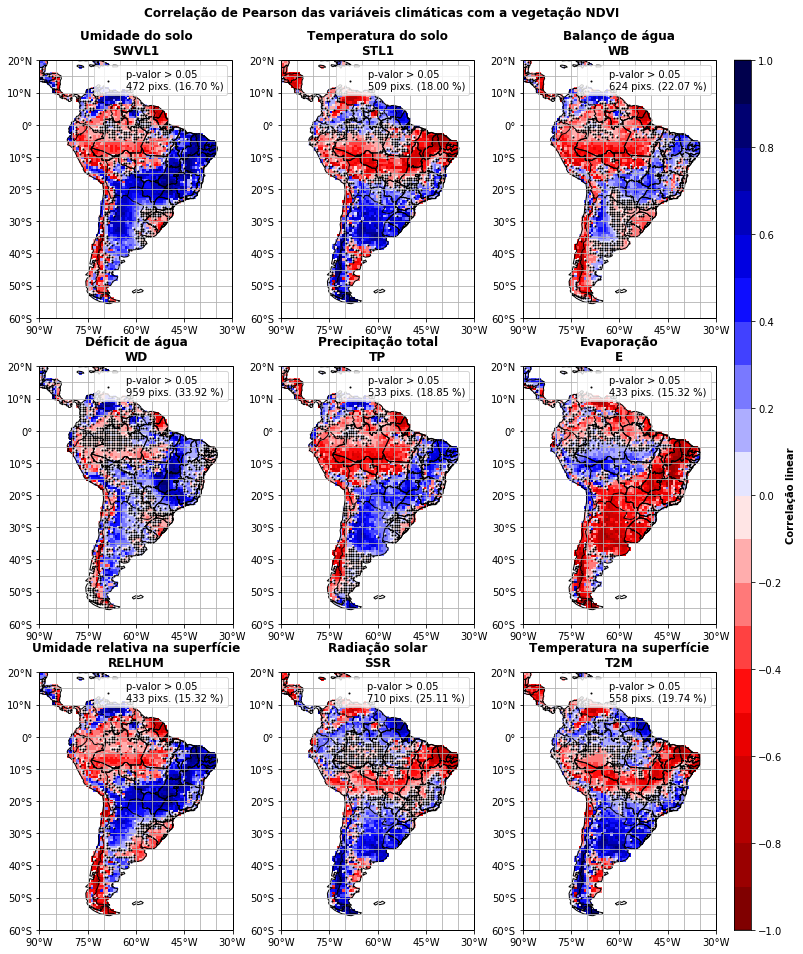

In [12]:
%%time

titles = [
    "Umidade do solo\n" + codes[1].upper(),
    "Temperatura do solo\n" + codes[2].upper(),
    "Balanço de água\n" + codes[3].upper(),
    "Déficit de água\n" + codes[4].upper(),
    "Precipitação total\n" + codes[5].upper(),
    "Evaporação\n" + codes[6].upper(),
    "Umidade relativa na superfície\n" + codes[7].upper(),
    "Radiação solar\n" + codes[8].upper(),
    "Temperatura na superfície\n" + codes[9].upper()
]

# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(15, 15))

axgr = AxesGrid(
    fig=fig, 
    rect=111, 
    axes_class=axes_class,
    nrows_ncols=(3, 3),
    axes_pad=0.675,
    cbar_location="right",
    cbar_mode="single",
    cbar_pad=0.25,
    cbar_size="3%",
    label_mode=""
)

# Make maps.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([loni, lonf, latf, lati], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-90, -15, 15), crs=projection)
    axis.set_yticks(np.arange(-60, 30, 10), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-90, -25, 5), ylocs=range(-60, 25, 5))        
   
    # Plot data on these maps.
    p = rhos[index].sel(stats="rho").where(rhos[index].land_mask == True).plot(
        ax=axis,
        vmin=-1.0,
        vmax=1.0,
        levels=np.arange(-1.0, 1.1, 0.1),
        cmap=plt.cm.seismic_r,
        add_colorbar=False,
        add_labels=False
    )

    axis.set_title(titles[index], weight="bold")
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(
            geoms=[state], 
            crs=projection, 
            facecolor="none", 
            edgecolor="black"
        )    

    # Statistical significant trends.
    mask = rhos[index].sel(stats="p_value").where(rhos[index].land_mask == True) > 0.05
    LON, LAT = np.meshgrid(mask.longitude.values, mask.latitude.values)

    # Insignificant linear relations.
    only_land = (~mask.where(mask.land_mask==True).isnull()).sum().values
    axis.plot(LON[mask], LAT[mask], ".k", markersize=2, 
              label="p-valor > 0.05\n" + str(mask.sum().values) + " pixs. " + \
                    str("(%.2f %%)" %(mask.sum().values / only_land * 100)), 
              transform=projection)
    # Legend.    
    axis.legend(loc=1)     
        
# Fill common colorbar.        
cb = axgr.cbar_axes[0].colorbar(p)
cb.set_label_text("Correlação linear", weight="bold")
cb.cbar_axis.set_ticks(np.arange(-1.0, 1.2, 0.2))        
plt.suptitle("Correlação de Pearson das variáveis climáticas com a vegetação NDVI", 
             weight="bold")
plt.subplots_adjust(top=0.93)    

# Save figures.
plt.savefig(fig_path + "ndvi_climate_pearson_pt.jpg", dpi=200, bbox_inches="tight")

In [13]:
%%time

# Correlations between vegetation and climate.
rhos = []
for index, DS in enumerate(DSs.values()):
    
    if index > 0: 
    
        # Select variables.
        da1 = DSs["NDVI_mm"].ndvi  # Always ndvi.  
        da2 = getattr(DS, codes[index])

        # Linear relationship.
        rho = cdlearn.statistics.correlation(da1, da2, lag=1)

        # Put mask.
        rho = cdlearn.pixels.EraInterimGrid.add_land_mask(rho)
    
        # Add to list of results.
        rhos.append(rho)

CPU times: user 8.22 s, sys: 316 ms, total: 8.54 s
Wall time: 6.35 s


CPU times: user 6.35 s, sys: 134 ms, total: 6.49 s
Wall time: 6.48 s


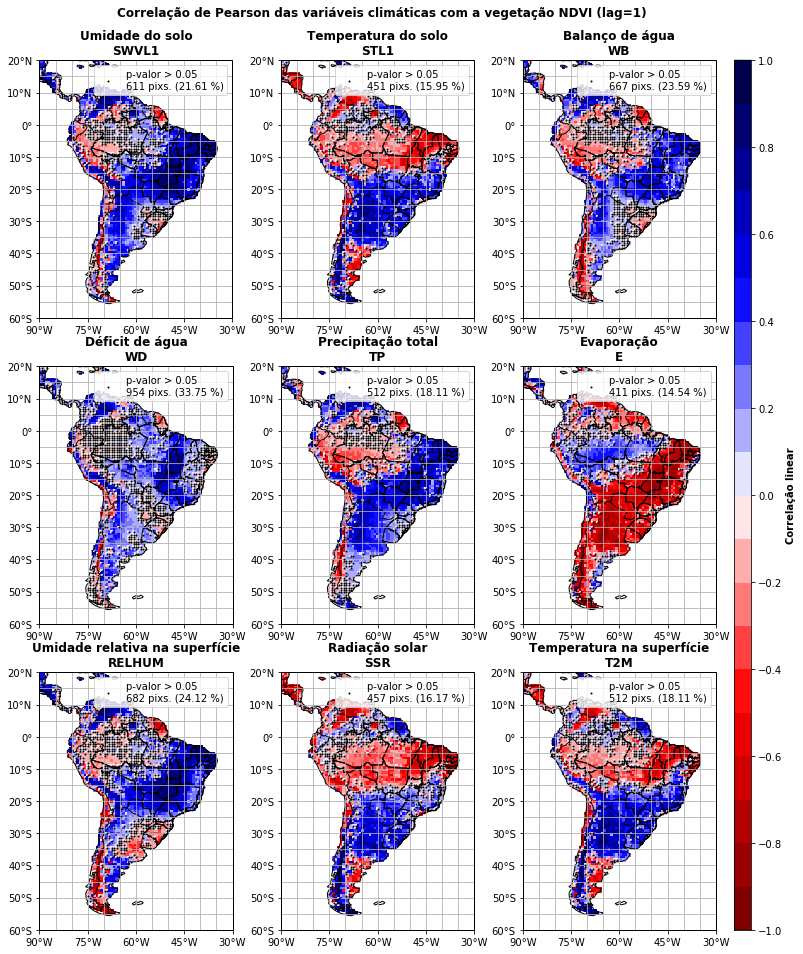

In [14]:
%%time

# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(15, 15))

axgr = AxesGrid(
    fig=fig, 
    rect=111, 
    axes_class=axes_class,
    nrows_ncols=(3, 3),
    axes_pad=0.675,
    cbar_location="right",
    cbar_mode="single",
    cbar_pad=0.25,
    cbar_size="3%",
    label_mode=""
)

# Make maps.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([loni, lonf, latf, lati], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-90, -15, 15), crs=projection)
    axis.set_yticks(np.arange(-60, 30, 10), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-90, -25, 5), ylocs=range(-60, 25, 5))        
   
    # Plot data on these maps.
    p = rhos[index].sel(stats="rho").where(rhos[index].land_mask == True).plot(
        ax=axis,
        vmin=-1.0,
        vmax=1.0,
        levels=np.arange(-1.0, 1.1, 0.1),
        cmap=plt.cm.seismic_r,
        add_colorbar=False,
        add_labels=False
    )

    axis.set_title(titles[index], weight="bold")
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(
            geoms=[state], 
            crs=projection, 
            facecolor="none", 
            edgecolor="black"
        )    

    # Statistical significant trends.
    mask = rhos[index].sel(stats="p_value").where(rhos[index].land_mask == True) > 0.05
    LON, LAT = np.meshgrid(mask.longitude.values, mask.latitude.values)

    # Insignificant linear relations.
    only_land = (~mask.where(mask.land_mask==True).isnull()).sum().values
    axis.plot(LON[mask], LAT[mask], ".k", markersize=2, 
              label="p-valor > 0.05\n" + str(mask.sum().values) + " pixs. " + \
                    str("(%.2f %%)" %(mask.sum().values / only_land * 100)), 
              transform=projection)
    # Legend.    
    axis.legend(loc=1)     
        
# Fill common colorbar.        
cb = axgr.cbar_axes[0].colorbar(p)
cb.set_label_text("Correlação linear", weight="bold")
cb.cbar_axis.set_ticks(np.arange(-1.0, 1.2, 0.2))        
plt.suptitle("Correlação de Pearson das variáveis climáticas com a vegetação NDVI" + \
             " (lag=1)", weight="bold")
plt.subplots_adjust(top=0.93)    

# Save figures.
plt.savefig(fig_path + "ndvi_climate_pearson_lag1_pt.jpg", dpi=200, bbox_inches="tight")

In [15]:
%%time

# Correlations between vegetation and climate.
rhos = []
for index, DS in enumerate(DSs.values()):
    
    if index > 0: 
    
        # Select variables.
        da1 = DSs["NDVI_mm"].ndvi  # Always ndvi.  
        da2 = getattr(DS, codes[index])

        # Linear relationship.
        rho = cdlearn.statistics.correlation(da1, da2, lag=2)

        # Put mask.
        rho = cdlearn.pixels.EraInterimGrid.add_land_mask(rho)
    
        # Add to list of results.
        rhos.append(rho)

CPU times: user 8.23 s, sys: 257 ms, total: 8.49 s
Wall time: 6.36 s


CPU times: user 6.54 s, sys: 97.2 ms, total: 6.64 s
Wall time: 6.64 s


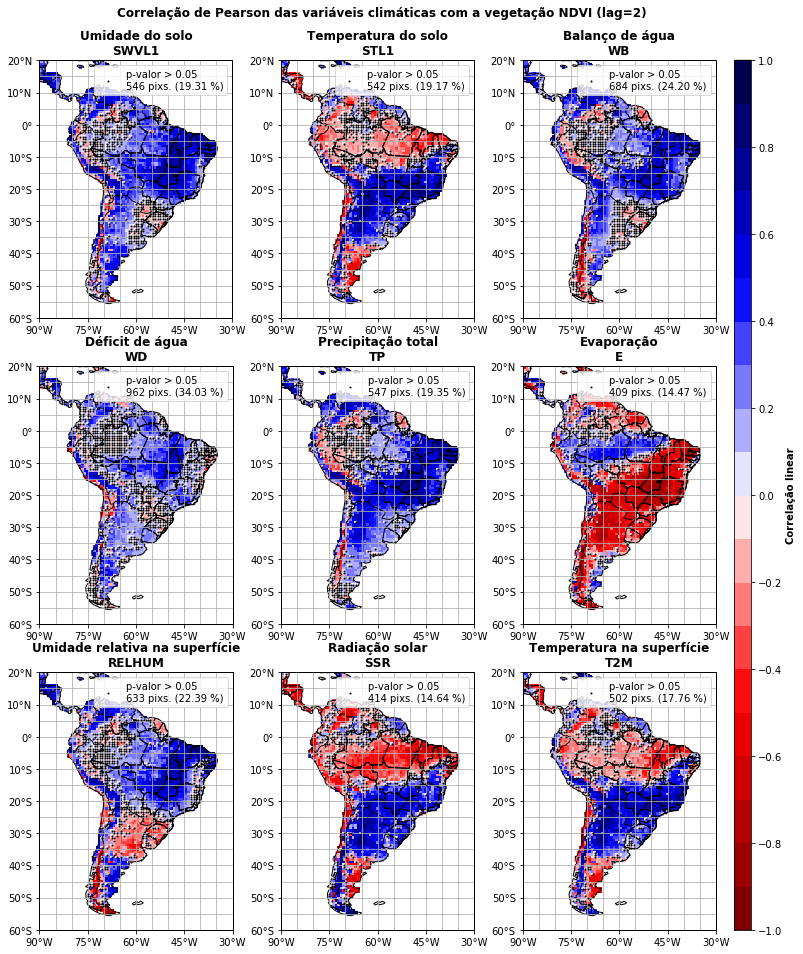

In [16]:
%%time

# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(15, 15))

axgr = AxesGrid(
    fig=fig, 
    rect=111, 
    axes_class=axes_class,
    nrows_ncols=(3, 3),
    axes_pad=0.675,
    cbar_location="right",
    cbar_mode="single",
    cbar_pad=0.25,
    cbar_size="3%",
    label_mode=""
)

# Make maps.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([loni, lonf, latf, lati], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-90, -15, 15), crs=projection)
    axis.set_yticks(np.arange(-60, 30, 10), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-90, -25, 5), ylocs=range(-60, 25, 5))        
   
    # Plot data on these maps.
    p = rhos[index].sel(stats="rho").where(rhos[index].land_mask == True).plot(
        ax=axis,
        vmin=-1.0,
        vmax=1.0,
        levels=np.arange(-1.0, 1.1, 0.1),
        cmap=plt.cm.seismic_r,
        add_colorbar=False,
        add_labels=False
    )

    axis.set_title(titles[index], weight="bold")
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(
            geoms=[state], 
            crs=projection, 
            facecolor="none", 
            edgecolor="black"
        )    

    # Statistical significant trends.
    mask = rhos[index].sel(stats="p_value").where(rhos[index].land_mask == True) > 0.05
    LON, LAT = np.meshgrid(mask.longitude.values, mask.latitude.values)

    # Insignificant linear relations.
    only_land = (~mask.where(mask.land_mask==True).isnull()).sum().values
    axis.plot(LON[mask], LAT[mask], ".k", markersize=2, 
              label="p-valor > 0.05\n" + str(mask.sum().values) + " pixs. " + \
                    str("(%.2f %%)" %(mask.sum().values / only_land * 100)), 
              transform=projection)
    # Legend.    
    axis.legend(loc=1)     
        
# Fill common colorbar.        
cb = axgr.cbar_axes[0].colorbar(p)
cb.set_label_text("Correlação linear", weight="bold")
cb.cbar_axis.set_ticks(np.arange(-1.0, 1.2, 0.2))        
plt.suptitle("Correlação de Pearson das variáveis climáticas com a vegetação NDVI" + \
             " (lag=2)", weight="bold")
plt.subplots_adjust(top=0.93)    

# Save figures.
plt.savefig(fig_path + "ndvi_climate_pearson_lag2_pt.jpg", dpi=200, bbox_inches="tight")

In [17]:
%%time

# Correlations between vegetation and climate.
rhos = []
for index, DS in enumerate(DSs.values()):
    
    if index > 0: 
    
        # Select variables.
        da1 = DSs["NDVI_mm"].ndvi  # Always ndvi.  
        da2 = getattr(DS, codes[index])

        # Linear relationship.
        rho = cdlearn.statistics.correlation(da1, da2, lag=3)

        # Put mask.
        rho = cdlearn.pixels.EraInterimGrid.add_land_mask(rho)
    
        # Add to list of results.
        rhos.append(rho)

CPU times: user 8.08 s, sys: 330 ms, total: 8.41 s
Wall time: 6.27 s


CPU times: user 6.52 s, sys: 98.6 ms, total: 6.62 s
Wall time: 6.63 s


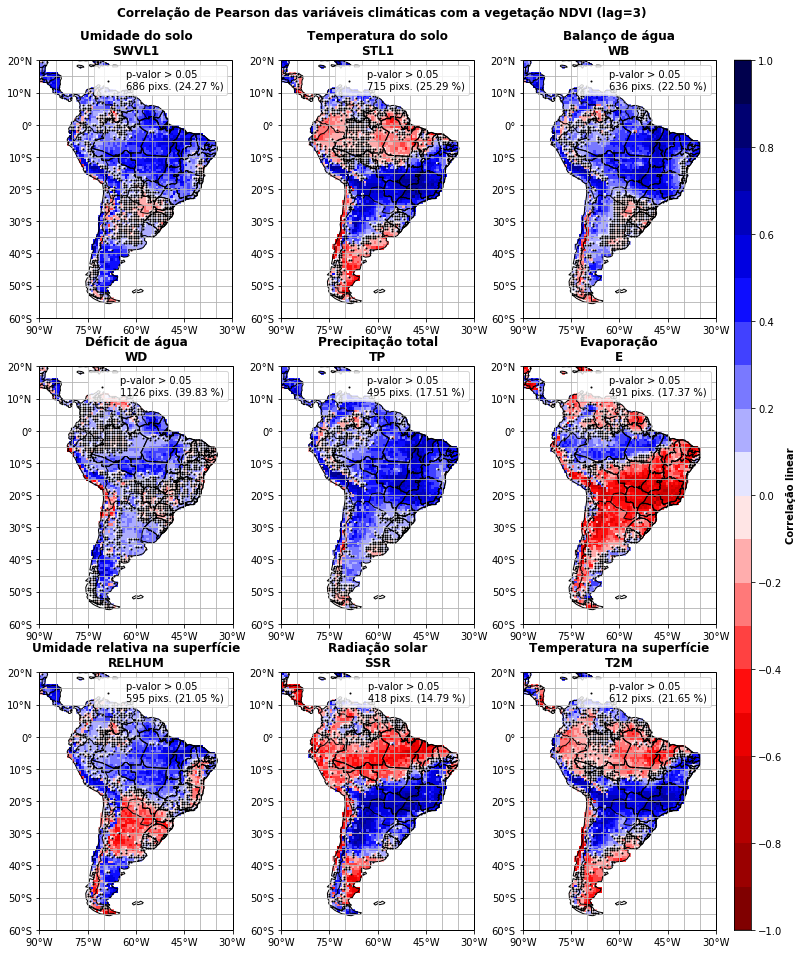

In [18]:
%%time

# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(15, 15))

axgr = AxesGrid(
    fig=fig, 
    rect=111, 
    axes_class=axes_class,
    nrows_ncols=(3, 3),
    axes_pad=0.675,
    cbar_location="right",
    cbar_mode="single",
    cbar_pad=0.25,
    cbar_size="3%",
    label_mode=""
)

# Make maps.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([loni, lonf, latf, lati], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-90, -15, 15), crs=projection)
    axis.set_yticks(np.arange(-60, 30, 10), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-90, -25, 5), ylocs=range(-60, 25, 5))        
   
    # Plot data on these maps.
    p = rhos[index].sel(stats="rho").where(rhos[index].land_mask == True).plot(
        ax=axis,
        vmin=-1.0,
        vmax=1.0,
        levels=np.arange(-1.0, 1.1, 0.1),
        cmap=plt.cm.seismic_r,
        add_colorbar=False,
        add_labels=False
    )

    axis.set_title(titles[index], weight="bold")
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(
            geoms=[state], 
            crs=projection, 
            facecolor="none", 
            edgecolor="black"
        )    

    # Statistical significant trends.
    mask = rhos[index].sel(stats="p_value").where(rhos[index].land_mask == True) > 0.05
    LON, LAT = np.meshgrid(mask.longitude.values, mask.latitude.values)

    # Insignificant linear relations.
    only_land = (~mask.where(mask.land_mask==True).isnull()).sum().values
    axis.plot(LON[mask], LAT[mask], ".k", markersize=2, 
              label="p-valor > 0.05\n" + str(mask.sum().values) + " pixs. " + \
                    str("(%.2f %%)" %(mask.sum().values / only_land * 100)), 
              transform=projection)
    # Legend.    
    axis.legend(loc=1)     
        
# Fill common colorbar.        
cb = axgr.cbar_axes[0].colorbar(p)
cb.set_label_text("Correlação linear", weight="bold")
cb.cbar_axis.set_ticks(np.arange(-1.0, 1.2, 0.2))        
plt.suptitle("Correlação de Pearson das variáveis climáticas com a vegetação NDVI" + \
             " (lag=3)", weight="bold")
plt.subplots_adjust(top=0.93)    

# Save figures.
plt.savefig(fig_path + "ndvi_climate_pearson_lag3_pt.jpg", dpi=200, bbox_inches="tight")

In [19]:
%%time

# Correlations between vegetation and climate.
rhos = []
for index, DS in enumerate(DSs.values()):
    
    if index > 0: 
    
        # Select variables.
        da1 = DSs["NDVI_mm"].ndvi  # Always ndvi.  
        da2 = getattr(DS, codes[index])

        # Linear relationship.
        rho = cdlearn.statistics.correlation(da1, da2, lag=6)

        # Put mask.
        rho = cdlearn.pixels.EraInterimGrid.add_land_mask(rho)
    
        # Add to list of results.
        rhos.append(rho)

CPU times: user 8.17 s, sys: 377 ms, total: 8.55 s
Wall time: 6.4 s


CPU times: user 7.23 s, sys: 170 ms, total: 7.4 s
Wall time: 7.41 s


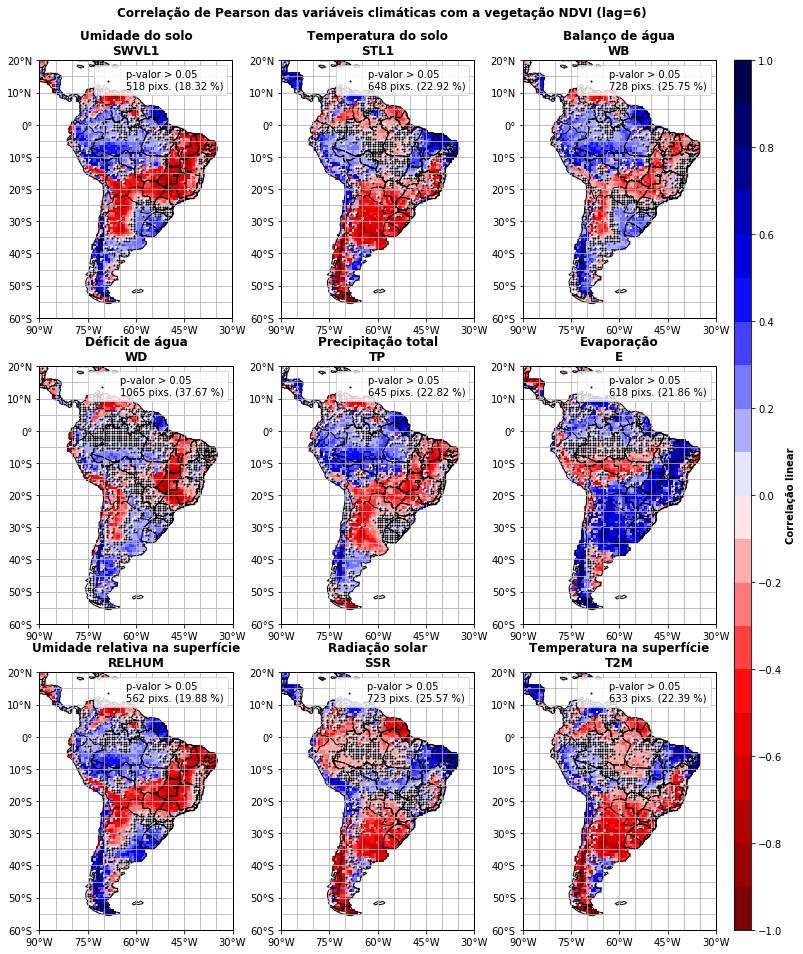

In [20]:
%%time

# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(15, 15))

axgr = AxesGrid(
    fig=fig, 
    rect=111, 
    axes_class=axes_class,
    nrows_ncols=(3, 3),
    axes_pad=0.675,
    cbar_location="right",
    cbar_mode="single",
    cbar_pad=0.25,
    cbar_size="3%",
    label_mode=""
)

# Make maps.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([loni, lonf, latf, lati], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-90, -15, 15), crs=projection)
    axis.set_yticks(np.arange(-60, 30, 10), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-90, -25, 5), ylocs=range(-60, 25, 5))        
   
    # Plot data on these maps.
    p = rhos[index].sel(stats="rho").where(rhos[index].land_mask == True).plot(
        ax=axis,
        vmin=-1.0,
        vmax=1.0,
        levels=np.arange(-1.0, 1.1, 0.1),
        cmap=plt.cm.seismic_r,
        add_colorbar=False,
        add_labels=False
    )

    axis.set_title(titles[index], weight="bold")
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(
            geoms=[state], 
            crs=projection, 
            facecolor="none", 
            edgecolor="black"
        )    

    # Statistical significant trends.
    mask = rhos[index].sel(stats="p_value").where(rhos[index].land_mask == True) > 0.05
    LON, LAT = np.meshgrid(mask.longitude.values, mask.latitude.values)

    # Insignificant linear relations.
    only_land = (~mask.where(mask.land_mask==True).isnull()).sum().values
    axis.plot(LON[mask], LAT[mask], ".k", markersize=2, 
              label="p-valor > 0.05\n" + str(mask.sum().values) + " pixs. " + \
                    str("(%.2f %%)" %(mask.sum().values / only_land * 100)), 
              transform=projection)
    # Legend.    
    axis.legend(loc=1)     
        
# Fill common colorbar.        
cb = axgr.cbar_axes[0].colorbar(p)
cb.set_label_text("Correlação linear", weight="bold")
cb.cbar_axis.set_ticks(np.arange(-1.0, 1.2, 0.2))        
plt.suptitle("Correlação de Pearson das variáveis climáticas com a vegetação NDVI" + \
             " (lag=6)", weight="bold")
plt.subplots_adjust(top=0.93)    

# Save figures.
plt.savefig(fig_path + "ndvi_climate_pearson_lag6_pt.jpg", dpi=200, bbox_inches="tight")